### Set up the simulation model (includes disturbances)

In [1]:
import do_mpc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import sin, cos, tan, pi, exp, sqrt, arctan2
import time

model_type = 'continuous'
sim_model = do_mpc.model.Model(model_type)

#Define the model parameters
m_11 = 50.05
m_22 = 84.36
m_33 = 17.21

Xu = 151.57
Yv = 132.5
Nr = 34.5

# Define the model variables
x = sim_model.set_variable(var_type='_x', var_name='x', shape=(1,1))
y = sim_model.set_variable(var_type='_x', var_name='y', shape=(1,1))
psi = sim_model.set_variable(var_type='_x', var_name='psi', shape=(1,1))
u = sim_model.set_variable(var_type='_x', var_name='u', shape=(1,1))
v = sim_model.set_variable(var_type='_x', var_name='v', shape=(1,1))
r = sim_model.set_variable(var_type='_x', var_name='r', shape=(1,1))
tau_c = sim_model.set_variable(var_type='_u', var_name='tau_c', shape=(3,1))
tau_d = sim_model.set_variable(var_type='_u', var_name='tau_d', shape=(3,1))

# Without coriolis matrix
sim_model.set_rhs('x', u*cos(psi) - v*sin(psi))
sim_model.set_rhs('y', u*sin(psi) + v*cos(psi))
sim_model.set_rhs('psi', r)
sim_model.set_rhs('u', (1/m_11)*(-Xu*u + tau_c[0] + tau_d[0]))
sim_model.set_rhs('v', (1/m_22)*(-Yv*v + tau_c[1] + tau_d[1]))
sim_model.set_rhs('r', (1/m_33)*(-Nr*r + tau_c[2] + tau_d[2]))

x0 = np.array([10, -5, 1.57, 0, 0, 0]).reshape(-1,1)
sim_model.x0 = x0
sim_model.setup()

### set up the MPC model

In [2]:
model_type = 'continuous'
mpc_model = do_mpc.model.Model(model_type)

#Define the model parameters
m_11 = 50.05
m_22 = 84.36
m_33 = 17.21

Xu = 151.57
Yv = 132.5
Nr = 34.5

# Define the model variables
x = mpc_model.set_variable(var_type='_x', var_name='x', shape=(1,1))
y = mpc_model.set_variable(var_type='_x', var_name='y', shape=(1,1))
psi = mpc_model.set_variable(var_type='_x', var_name='psi', shape=(1,1))
u = mpc_model.set_variable(var_type='_x', var_name='u', shape=(1,1))
v = mpc_model.set_variable(var_type='_x', var_name='v', shape=(1,1))
r = mpc_model.set_variable(var_type='_x', var_name='r', shape=(1,1))
tau_c = mpc_model.set_variable(var_type='_u', var_name='tau_c', shape=(3,1))

# Without coriolis matrix
mpc_model.set_rhs('x', u*cos(psi) - v*sin(psi))
mpc_model.set_rhs('y', u*sin(psi) + v*cos(psi))
mpc_model.set_rhs('psi', r)
mpc_model.set_rhs('u', (1/m_11)*(-Xu*u + tau_c[0]))
mpc_model.set_rhs('v', (1/m_22)*(-Yv*v + tau_c[1]))
mpc_model.set_rhs('r', (1/m_33)*(-Nr*r + tau_c[2]))

mpc_model.x0 = x0
mpc_model.setup()

#### Set simulation parameters

In [3]:
simulator = do_mpc.simulator.Simulator(sim_model)
dt = 0.1
simulator.set_param(t_step = dt)
simulator.setup()
simulator.x0 = x0

CasADi - 2023-05-21 00:37:01 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:499]


# Set up MPC controller

In [4]:
mpc = do_mpc.controller.MPC(mpc_model)
setup_mpc = {
    'n_horizon': 40,
    't_step': 0.1,
    'n_robust': 0,
    'store_full_solution': True,
}

input_cost_matrix = np.diag([1e-7, 1e-2, 1e-7])
mpc.set_param(**setup_mpc)
lterm = 10*(x**2 + y**2 + 0*psi**2) + u**2 + v**2 + r**2 + tau_c.T @ input_cost_matrix @ tau_c
mterm = 10*(x**2 + y**2 + 0*psi**2) + u**2 + v**2 + r**2
mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(
    tau_c=0.001
    )

# Lower bounds on thrusts:
mpc.bounds['lower','_u', 'tau_c'] = np.array([-200, -200, -200]).reshape(-1,1)
# Upper bounds on thrusts:
mpc.bounds['upper','_u', 'tau_c'] = np.array([200, 200, 200]).reshape(-1,1)

## simulate with mpc control loop

In [5]:
%%capture
mpc.setup()
mpc.x0 = x0
mpc.set_initial_guess()
sim_time = 10

#generate random disturbance
tau_d = np.zeros((3,1))
start_time = time.time()

for i in range(int(sim_time/dt)):
    u0 = mpc.make_step(x0)
    tau_d = 100*np.random.normal(0, 0.1, (3,1))
    sim_input = np.array([u0, tau_d]).reshape(-1,1)
    x0 = simulator.make_step(sim_input)

#find average time per iteration
end_time = time.time()
avg_time = (end_time - start_time)/int(sim_time/dt)
print("Average time per iteration: ", avg_time)

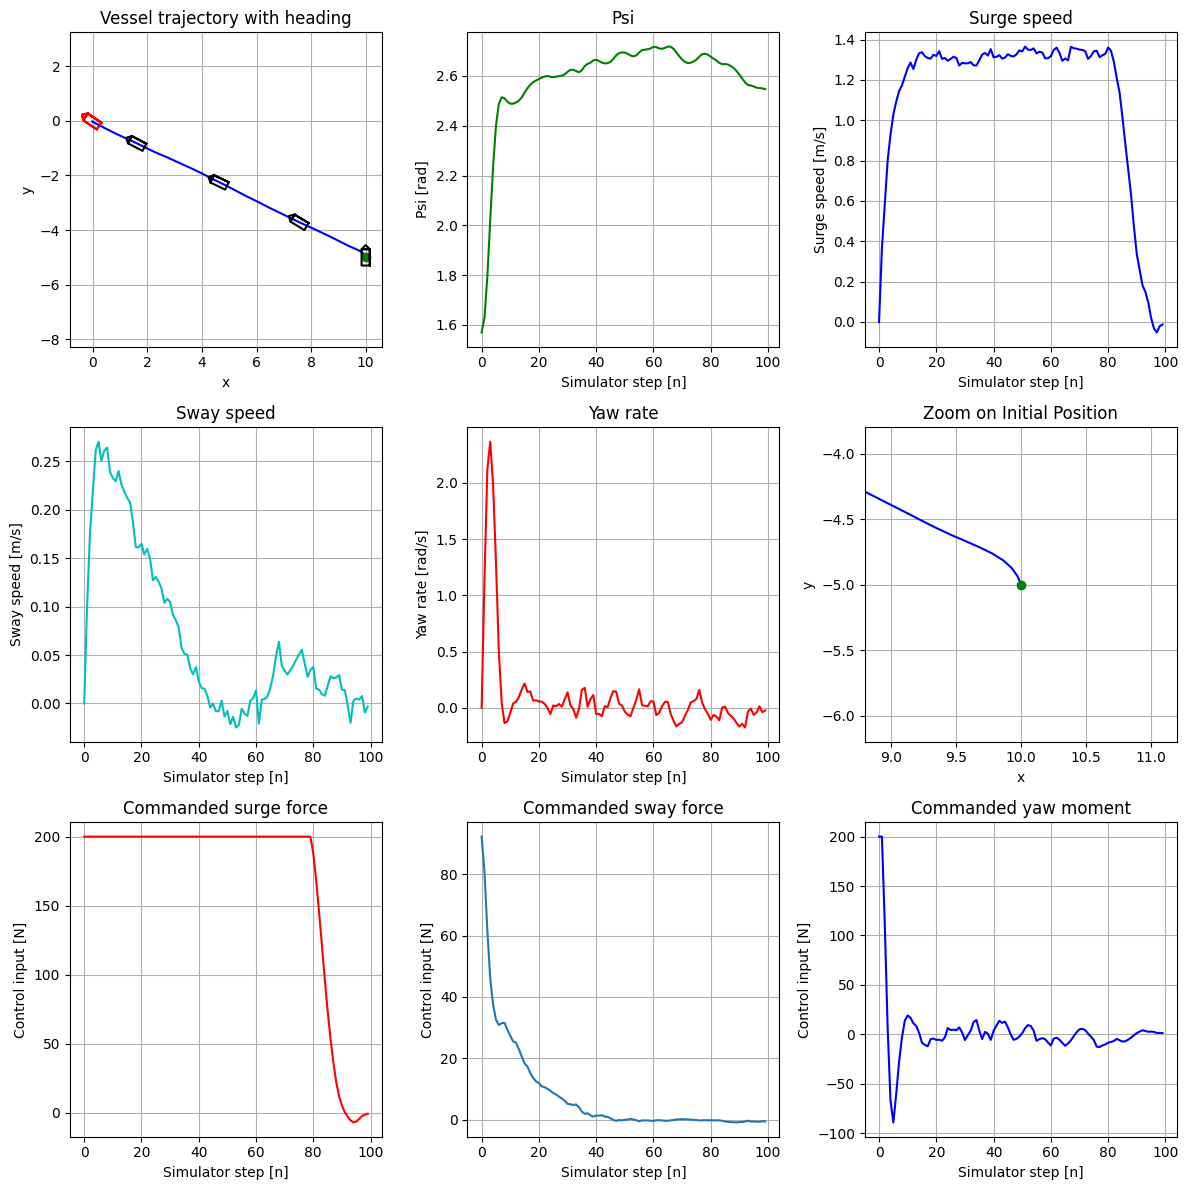

In [6]:
# Define function to draw a simple "boat"
def draw_boat(x, y, psi, ax, length=0.6, width=0.3, color='k'):
    # Define the boat's body (rectangle) and bow (triangle)
    body = np.array([[-length/2, -length/2, length/2, length/2, -length/2],
                     [-width/2, width/2, width/2, -width/2, -width/2]])
    bow = np.array([[length/2, length/2, 3*length/4, length/2],
                    [-width/2, width/2, 0, -width/2]])
    boat = np.concatenate((body, bow), axis=1)
    # Define the rotation matrix
    R = np.array([[np.cos(psi), -np.sin(psi)], [np.sin(psi), np.cos(psi)]])
    # Apply rotation and shift
    boat = R @ boat + np.array([[x], [y]])
    # Draw the boat on the plot
    ax.plot(boat[0, :], boat[1, :], color)

# Create a figure
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Get the simulation data
data = simulator.data

# Extract x, y, u, and r and convert them to numpy arrays
x_data = np.array(data['_x', 'x']).squeeze()
y_data = np.array(data['_x', 'y']).squeeze()
psi_data = np.array(data['_x', 'psi']).squeeze()
u_data = np.array(data['_x', 'u']).squeeze()
v_data = np.array(data['_x', 'v']).squeeze()
r_data = np.array(data['_x', 'r']).squeeze()
tau_c_data = np.array(data['_u', 'tau_c']).squeeze()




# First subplot: Vessel trajectory
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0,0].set_title('Vessel trajectory')
axs[0,0].plot(x_data, y_data, 'b', label='Vessel trajectory')
axs[0,0].plot(x_data[0], y_data[0], 'go', label='Start')
axs[0,0].axis('equal')

# Draw the trajectory with boats          
N_boat = 4  # Number of boat instances to draw
for i in np.linspace(0, len(x_data)- 1, N_boat+1, dtype=int):  # indices along the trajectory
    draw_boat(x_data[i], y_data[i], psi_data[i], axs[0, 0], color='k')

#draw final boat
draw_boat(x_data[-1], y_data[-1], psi_data[-1], axs[0, 0], color='r')

# Set labels and title
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].set_title('Vessel trajectory with heading')


# Second subplot: Psi
axs[0,1].set_xlabel('Simulator step [n]')
axs[0,1].set_ylabel('Psi [rad]')
axs[0,1].set_title('Psi')
axs[0,1].plot(psi_data, 'g', label='Psi')

# Third subplot: Surge speed
axs[0,2].set_xlabel('Simulator step [n]')
axs[0,2].set_ylabel('Surge speed [m/s]')
axs[0,2].set_title('Surge speed')
axs[0,2].plot(u_data, 'b', label='Surge speed')

# Fourth subplot: Sway speed
axs[1,0].set_xlabel('Simulator step [n]')
axs[1,0].set_ylabel('Sway speed [m/s]')
axs[1,0].set_title('Sway speed')
axs[1,0].plot(v_data, 'c', label='Sway speed')

# Fifth subplot: Yaw rate
axs[1,1].set_xlabel('Simulator step [n]')
axs[1,1].set_ylabel('Yaw rate [rad/s]')
axs[1,1].set_title('Yaw rate')
axs[1,1].plot(r_data, 'r', label='Yaw rate')

# Sixth subplot: Zoomed initial position
axs[1,2].set_xlabel('x')
axs[1,2].set_ylabel('y')
axs[1,2].set_title('Zoom on Initial Position')
axs[1,2].plot(x_data, y_data, 'b', label='Vessel trajectory')

# Set x and y limits to zoom in around initial position
zoom_factor = 1.2  # adjust this for different levels of zoom
x_init, y_init = x_data[0], y_data[0]
axs[1,2].set_xlim(x_init - zoom_factor, x_init + zoom_factor)
axs[1,2].set_ylim(y_init - zoom_factor, y_init + zoom_factor)

# Mark the initial and final position
axs[1,2].plot(x_init, y_init, 'go', label='Start')
axs[1,2].plot(0, 0, 'ro', label='End')

# control inputs
axs[2,0].set_xlabel('Simulator step [n]')
axs[2,0].set_ylabel('Control input [N]')
axs[2,0].set_title('Commanded surge force')
axs[2,0].plot(tau_c_data[:,0], 'r', label='Surge force')

axs[2,1].set_xlabel('Simulator step [n]')
axs[2,1].set_ylabel('Control input [N]')
axs[2,1].set_title('Commanded sway force')
axs[2,1].plot(tau_c_data[:,1], '', label='Surge force')

axs[2,2].set_xlabel('Simulator step [n]')
axs[2,2].set_ylabel('Control input [N]')
axs[2,2].set_title('Commanded yaw moment')
axs[2,2].plot(tau_c_data[:,2], 'b', label='Surge force')


# Ensure subplots do not overlap
#turn on grid
axs[0,0].grid()
axs[0,1].grid()
axs[0,2].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[1,2].grid()
axs[2,0].grid()
axs[2,1].grid()
axs[2,2].grid()

plt.tight_layout()

